Notes:
 * revised and tuned configuration, updated views
 * training on full dataset (including Y3, new light curves, fixes)
 * trained with updated star radius estimations, multiple duplicates removed
 * removed instar examples

In [1]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/revised_tuned_35_run_1'
data_files = '/mnt/tess/astronet/tfrecords-35-train/*'
tces_file = '/mnt/tess/astronet/tces-v12-train.csv'

nruns = 1

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/revised_tuned_35_run_1/1/AstroCNNModel_revised_tuned_20220219_190314']

In [2]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
19698 records


In [24]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.8

In [25]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [26]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [27]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [28]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.8904899135446686
Precision: 0.965625


In [29]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

384744604
38680704
389364577
391812839
288346083
298757219
28690049
312758663
321915222
326974824
346541355
310004006
387829772
417146817
13828577
155001079
186400565
26516151
28224552
157018051
202489696
359030548
113272112
114053589
118274531
118798035
119153127
119774374
120397217
128966834
141029164
424986927
425064757
425561347
425721385
446348261
446523110
464592499
464597067
465989972
49137560
49390070
232540264
369860950
373849740
373917626
375059587
376778166
376936788
379464439
380822002
380822025
380991167
381366555
382312510
382366334
383390264
383390727
383390914
383716793
136971594
199795179
237202699
237217334
256299194
276936242
277015008
277099925
277123828
277373239
277373256
278270436
417126296
69259807
142963071
14742096
167569135
195416956
357046804
364951842
366989877
27491137
365203184
198410480
300019694
300405121
30312902
303842892
304343052
304729846
306268580
30639928
306511505
30931288
309434156
309486483
314865962
31532677
318612970
48356677
429357337
76196

In [30]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

394233079
396957480
18252911
156993882
119384992
456588598
464488581
49449799
369864019
370134610
370227480
373843852
384077498
384195094
43667308
98937256
272358852
276793626
277027632
83408987
117631084
17131560
360961597
30113151
301896004
30193373
306108833
306270678
31415158
4933576
358249491
440738016
453009027
454140642
463974233
340217291
349154278
349373192
279957439
279958091
280097876
284196025
79655149
88353444
231792014
25078924
300029336
305582965
32152605
327593978
13346068
76698707
29984021
261136311
298295539
378275445
277566483
404768904
404851226
405864709
354959477
414897731
220474216
237944314
105450460
131857479


In [82]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 18252911)

,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,
18252911,0.939296,0.006171,0.019639,0.020084,0.000492


In [86]:
pl[pl.index == 373843852]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,,,,,,,
373843852,1,0,0,0,0,1,0,0,1,0,0


### PR curve

In [33]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_e']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [34]:
num_cond_pos = int(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9848331484695478, max R: 1.0, max P: 1.0
100% recall at: 40%, threshold: 0.00278005886083338


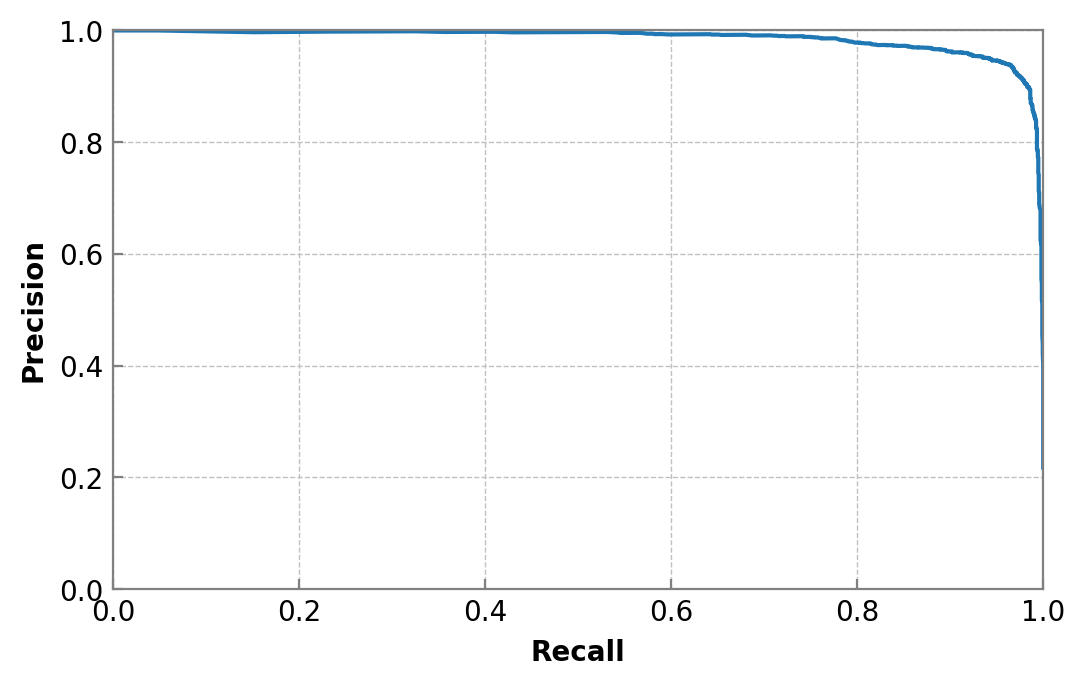

In [35]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    ps.append(p)
    rs.append(r)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)